In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

from torch import Tensor
from torch.optim.optimizer import Optimizer, required
from typing import List, Optional

In [2]:
SEED = 512

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


# prepare dataset

In [3]:
ROOT = '.data'
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


# optimizer

# Define MLP Model

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        # print(y_pred)
        return y_pred, h_2


def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [8]:
class PSO_Optimizer(Optimizer):
    def __init__(self, params, w = 1, c1=1, c2= 1.5):
        defaults = dict(w=w, c1=c1, c2=c2)
        super(PSO_Optimizer, self).__init__(params, defaults)
        self.velocity = [[layer_param for layer_param in group['params']] for group in params]
        

    def __setstate__(self, state):
        super().__setstate__(state)

    @torch.no_grad()
    def step(self, idx_gbest, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        for particle_id, group in enumerate(self.param_groups):
            for idx, p in enumerate(group['params']):
                if p.grad is not None:
                  if int(torch.sum(p.grad).detach()) != 0:
                    temp = p.clone()
                    r1, r2 = random.random(), random.random()
                    term1 = self.velocity[particle_id][idx] * group['w']
                    term2 = p.grad/(torch.norm(p.grad)**2) * group['c1'] * r1
                    term3 = (self.param_groups[idx_gbest]['params'][idx] - temp ) * group['c2'] * r2
                    self.velocity[particle_id][idx] = term1 - term2 + term3
                    p.add_(self.velocity[particle_id][idx])
            group['w'] = group['w'] * 0.9
            if group['c2'] > 0.05:
              group['c2'] -= 0.001
        return loss

In [13]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10
EPOCHS = 10
NUM_PARTICLES = 5
particles = [MLP(INPUT_DIM, OUTPUT_DIM) for i in range(NUM_PARTICLES)]
optimizer = PSO_Optimizer([{'params' : particles[i].parameters()} for i in range(NUM_PARTICLES)])
gbest_idx = 0
flag = True
gbest_loss = float('inf')
fitness_fn = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fitness_fn = fitness_fn.to(device)
for epoch in trange(EPOCHS):
    epoch_loss = torch.zeros((NUM_PARTICLES,))
    epoch_acc = torch.zeros((NUM_PARTICLES,))
    start_time = time.monotonic()
    # train 
    count = 0
    for (x, y) in tqdm(train_iterator, desc="Training", leave=False): 
      optimizer.zero_grad()
      x = x.to(device)
      y = y.to(device)
      for j, particle in enumerate(particles):
        particle = particle.to(device)
        particle.train() 
        y_pred, _ = particle(x)
        loss = fitness_fn(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        epoch_loss[j] += loss.item()
        epoch_acc[j] += acc.item()
      gbest_idx = np.argmin(epoch_loss)
      optimizer.step(gbest_idx)
    print(gbest_idx)
    train_loss, train_acc = epoch_loss[:] / len(train_iterator), epoch_acc[:] / len(train_iterator)
    print('train_acc: ', train_acc)
    print('train loss: ', train_loss)
best_model = np.argmax(train_acc)
torch.save(particles[best_model].state_dict(), 'tut1-model.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

tensor(3)
train_acc:  tensor([0.1303, 0.1527, 0.1651, 0.8231, 0.1773])
train loss:  tensor([3.8440, 3.6800, 3.7938, 0.5621, 3.4427])


Training:   0%|          | 0/422 [00:00<?, ?it/s]

tensor(3)
train_acc:  tensor([0.1147, 0.1719, 0.1679, 0.8968, 0.1631])
train loss:  tensor([4.5987, 4.2039, 4.1063, 0.3484, 3.9102])


Training:   0%|          | 0/422 [00:00<?, ?it/s]

tensor(3)
train_acc:  tensor([0.1742, 0.2395, 0.2560, 0.9137, 0.2022])
train loss:  tensor([4.0312, 3.6401, 3.4185, 0.2973, 3.4234])


Training:   0%|          | 0/422 [00:00<?, ?it/s]

tensor(3)
train_acc:  tensor([0.6826, 0.6943, 0.7106, 0.9177, 0.6967])
train loss:  tensor([1.0836, 1.0918, 1.0072, 0.2905, 1.0304])


Training:   0%|          | 0/422 [00:00<?, ?it/s]

tensor(3)
train_acc:  tensor([0.8118, 0.8075, 0.8345, 0.9238, 0.8366])
train loss:  tensor([0.6333, 0.6484, 0.5502, 0.2726, 0.5503])


Training:   0%|          | 0/422 [00:00<?, ?it/s]

tensor(3)
train_acc:  tensor([0.8015, 0.8120, 0.8158, 0.9269, 0.8360])
train loss:  tensor([0.6835, 0.6394, 0.6164, 0.2604, 0.5624])


Training:   0%|          | 0/422 [00:00<?, ?it/s]

tensor(3)
train_acc:  tensor([0.7700, 0.8038, 0.8240, 0.9284, 0.8302])
train loss:  tensor([0.7867, 0.6687, 0.6157, 0.2523, 0.5839])


Training:   0%|          | 0/422 [00:00<?, ?it/s]

tensor(3)
train_acc:  tensor([0.7993, 0.7981, 0.8268, 0.9302, 0.8225])
train loss:  tensor([0.6879, 0.6866, 0.5929, 0.2493, 0.6255])


Training:   0%|          | 0/422 [00:00<?, ?it/s]

tensor(3)
train_acc:  tensor([0.7706, 0.7916, 0.8146, 0.9328, 0.7945])
train loss:  tensor([0.8012, 0.7088, 0.6509, 0.2441, 0.7146])


Training:   0%|          | 0/422 [00:00<?, ?it/s]

tensor(3)
train_acc:  tensor([0.7553, 0.7841, 0.7903, 0.9353, 0.7722])
train loss:  tensor([0.8571, 0.7384, 0.7422, 0.2341, 0.7939])


# test 

In [15]:
# model = MLP(INPUT_DIM, OUTPUT_DIM)
# model.load_state_dict(torch.load('tut1-model.pt'))
test_loss, test_acc = evaluate(particles[4], test_iterator, fitness_fn, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.608 | Test Acc: 81.03%


In [16]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

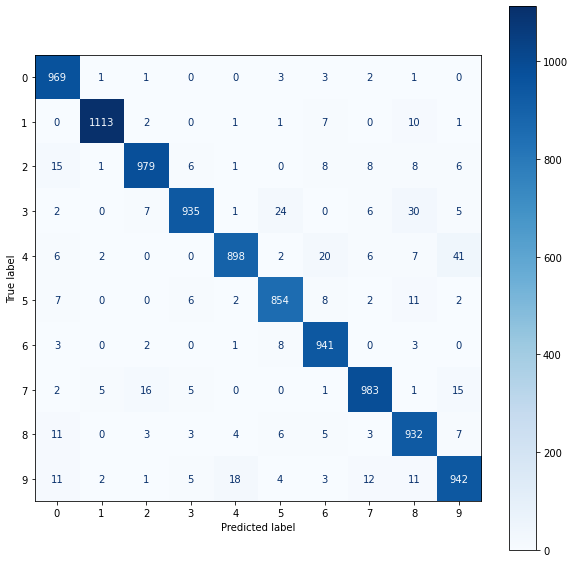

In [18]:
model = model.to(device)
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)
